# MNIST Digit Addition Problem

Consider a task where one needs to learn a classifier $\mathtt{addition(X,Y,N)}$ where $\mathtt{X}$ and $\mathtt{Y}$ are images of digits (the MNIST data set will be used), and $\mathtt{N}$ is a natural number corresponding to the sum of these digits. The classifier should return an estimate of the validity of the addition ($0$ is invalid, $1$ is valid). 

For instance, if $\mathtt{X}$ is an image of a 0 and $\mathtt{Y}$ is an image of a 9:
- if $\mathtt{N} = 9$, then the addition is valid; 
- if $\mathtt{N} = 4$, then the addition is not valid. 

A natural approach is to seek to first 1) learn a single digit classifier, then 2) benefit from knowledge readily available about the properties of addition.
For instance, suppose that a predicate $\mathrm{digit}(x,d)$ gives the likelihood of an image $x$ being of digit $d$, one could query with LTN:    
$$
\exists d_1,d_2 : d_1+d_2= \mathtt{N} \ (\mathrm{digit}(\mathtt{X},d_1)\land \mathrm{digit}(\mathtt{Y},d_2))
$$
and use the satisfaction of this query as the output of $\mathtt{addition(X,Y,N)}$ .


The challenge is the following:
- We provide, in the data, pairs of images $\mathtt{X}$, $\mathtt{Y}$ and the result of the addition $\mathtt{N}$ (final label),
- We do **not** provide the intermediate labels, the correct digits for $d_1$, $d_2$.

Regardless, it is possible to use the equation above as background knowledge to train $\mathrm{digit}$ with LTN.
In contrast, a standard neural network baseline cannot incorporate such intermediate components as nicely.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import logictensornetworks as ltn
import baselines, data, commons
import matplotlib.pyplot as plt

## Data

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.

Result label is 9


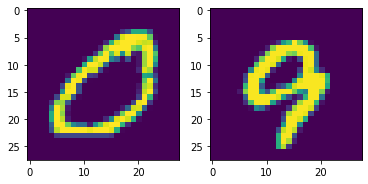

In [2]:
ds_train, ds_test = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=2,
        op=lambda args: args[0]+args[1])

# Visualize one example
x, y, z = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0])

## LTN

In [3]:
logits_model = baselines.SingleDigit()
Digit = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model))

d1 = ltn.variable("digits1", range(10))
d2 = ltn.variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

Notice the use of `Diag`: when grounding $x$,$y$,$n$ with three sequences of values, the $i$-th examples of each variable are matching. 
That is, `(images_x[i],images_y[i],labels[i])` is a tuple from our dataset of valid additions.
Using the diagonal quantification, LTN aggregates pairs of images and their corresponding result, rather than any combination of images and results. 
    
Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training) that could add up to the result label (given during training), we incorporate symbolic information into the system.

In [4]:
@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.variable("x", images_x)
    images_y = ltn.variable("y", images_y)
    labels_z = ltn.variable("z", labels_z)
    return Forall(
            ltn.diag(images_x,images_y,labels_z),
            Exists(
                (d1,d2),
                And(Digit([images_x,d1]),Digit([images_y,d2])),
                mask_vars=[labels_z,d2,d1],
                mask_fn=lambda vars: tf.equal(vars[0],vars[1]+vars[2]),
                p=p_schedule
            ),
            p=2
        )

images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
axioms(images_x, images_y, labels_z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010578215>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}

@tf.function
def train_step(images_x, images_y, labels_z, **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model(images_x),axis=-1)
    predictions_y = tf.argmax(logits_model(images_y),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x, images_y, labels_z, **parameters):
    # loss
    loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model(images_x),axis=-1)
    predictions_y = tf.argmax(logits_model(images_y),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))

Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}


In [7]:
commons.train(
    20,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    scheduled_parameters=scheduled_parameters
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0, train_loss: 0.9285, train_accuracy: 0.4328, test_loss: 0.8680, test_accuracy: 0.7242
Epoch 1, train_loss: 0.8546, train_accuracy: 0.8457, test_loss: 0.8525, test_accuracy: 0.7986
Epoch 2, train_loss: 0.8439, train_accuracy: 0.8986, test_loss: 0.8480, test_accuracy: 0.8274
Epoch 3, train_loss: 0.8398, train_accuracy: 0.9176, test_loss: 0.8439, test_accuracy: 0.8522
Epoch 4, train_loss: 0.6526, train_accuracy: 0.9109, test_loss: 0.6660, test_accuracy: 0.8462
Epoch 5, train_loss: 0.6326, train_acc